In [1]:
import sys
import os

# Add the Code folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Code')))

from CLfitter import *

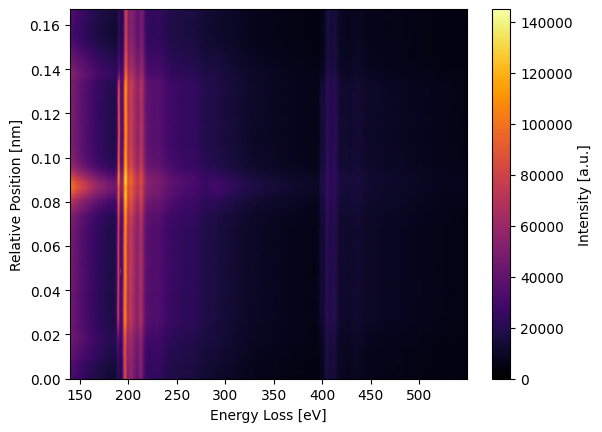

In [2]:
path_to_data = "../data/008_core_loss_line_020evpx_1mm.dm3"

params = {  'E_0'   : 300e3,  # eV
            'beta'  : 1e-3,    # eV
        }

clfit = CoreLossFitter(**params)
clfit.read_from_dm3(path_to_data)
clfit.plot()

### Data Alignment

Alignment of the data can be done in two ways, depending on if the ZLP is available for each spectrum.

If the zero loss peak is available for each spectrum, everything can be aligned by setting the maximum intensity equal to zero. 

If only some ZLP's are available, like the first and the last, all spectra that have the ZLP are aligned. The shifts are calculated from these aligned spectra, and the shifts of all other values are inter-/extrapolated from this.

If no ZLP's are available, no absolute energy loss can be determined. Still, the relative energy losses should be the same to further use the data. Aligning this data can be achieved by taking a reference spectrum $I_\text{reference}(E)$ and cross correlating every other spectrum $I_i(E)$ with this reference. Then every spectrum is shifted by $\text{shift}=\text{argmax}\left(I_\text{reference}(E)~\star~I_i(E)\right)$


In this example the ZLP is not known, so the first spectrum is used as a reference for the cross correlation.

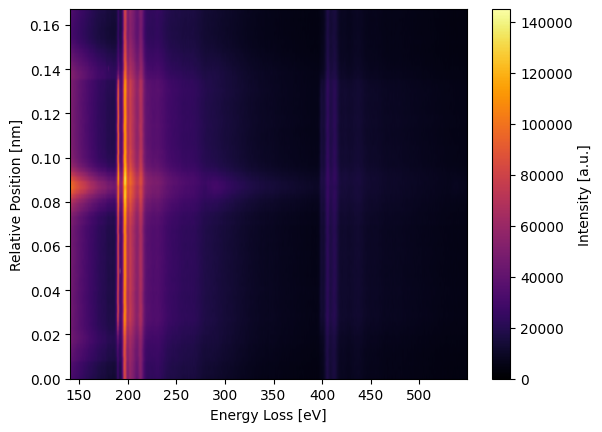

In [3]:
clfit.align_data(50)
clfit.plot()


### Data Normalization

To quantitatively compare different spectra, all spectra need to be normalized. The method employed to normalize depends on the availability of the low-loss region. 

If the low-loss region is available for all spectra, each spectra can be normalized by scaling the spectra such that the cross section of the low-loss region is set to 1 in arbitrary units. The cross section can be calculated by taking the integral of the entire low-loss region with respect to the energy loss.

If no low-loss region is known, the first value at constant energy loss of each spectrum are set to the same number, like 1. To avoid errors the data should first be aligned.

In this case the ZLP is not known so the last method is used


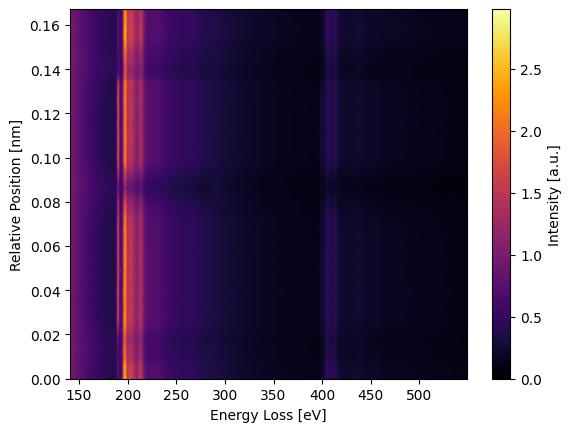

In [4]:
clfit.normalize_by_first_value()
clfit.plot()

We are interested in a single edge at a time, so we window the data to capture only the first edge, which in this case is the boron K-edge, for which we take 175 to 250 eV

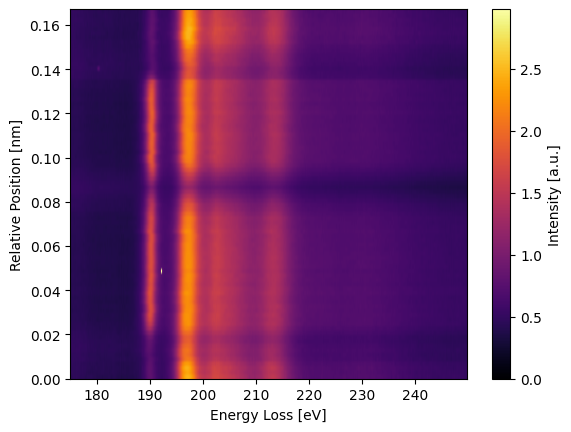

In [5]:
clfit.window_data(175,250)
clfit.plot()

### Least Squares Power-law Background fit

Background subtraction first requires knowing the background. This is achieved by first windowing the spectrum to get a spectrum that has not discernible features before the first edge. The region before the onset of the first edge is then fitted using a least squares approach to a power-law model shown below. 

$$
f(E) = A\cdot E^{-r}
$$

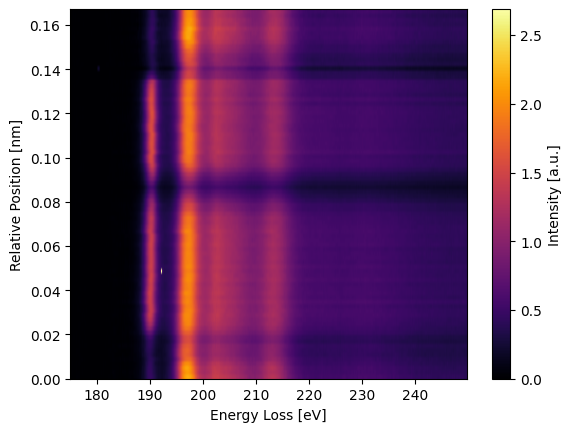

In [6]:
clfit.get_background_fit(188)
clfit.plot()

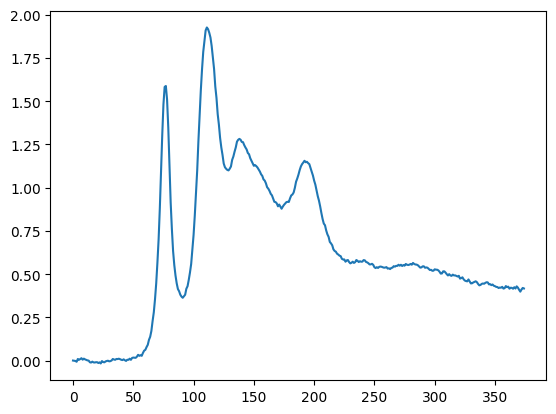

In [10]:
plt.plot(clfit.core_loss_data_changed[30])

#### unclear how to add this; Definition finestructure still a bit unclear.
Take for example a chemical shift w.r.t. an unperturbed edge. Is what happens that the whole edge gets shifted, or is it that states that were previously available are now unavailable. This would mean that the spectrum is not shifted, but merely multiplied with a DOS function that differs from the DOS of the unperturbed atom. What follows is a method, but the validity of this method is not entirely clear.

### Edge Subtraction 

Subtracting the unperturbed edges from the spectrum is done by first calculating the edge shapes, as described in section 1.1. This gives the edge shape of edge $i$ $I_\text{edge}^i(E)$, unperturbed by fine structure.

These calculated edge shapes are fitted to the spectrum using a least squares approach. For this a linear interpolation function is created out of these edge shapes using $\texttt{scipy.interpolate.interp1d}$. With this the spectrum is fitted to equation \ref{eq:edgefit} with fit parameters $A$ and $\Delta E$


$$    f(E) = \sum A\cdot I^i_\text{edge}(E+\Delta E)$$


Determining the optimal fit for the edges is challenging. Post-onset, the edges follow an approximate power-law shape, while pre-onset, they remain at zero. Since shifting a power law by a relatively small amount (e.g., 10 eV at an energy loss of 400 eV) does not significantly alter its shape, and a zero function remains unchanged under translation, the fitting process, based on shifting and scaling, is most effective in the edge onset region. However, this region also contains the most fine structure, making it difficult to isolate the underlying edge shape for accurate fitting.

This issue cannot be resolved by simply adding more terms to the fitting function, as the fine structure is too unpredictable to model accurately. This leaves two options when fitting with the least squares method: fitting the entire spectrum, which results in a negative tail; or excluding the ELNES region, leading to an incorrect shift.


In [8]:
#get simulated edge from the GOS tables
clfit.get_simulated_edge('B', 'K')
clfit.get_edge_fit()
clfit.plot()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/Dirac_GOS.gosh', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)